## Who should be my friend?

**Ansh Poonia**

In [1]:
# Importing all the required libraries  

import numpy as np
import pandas as pd
import networkx as net
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score
import dgl
import torch
import torch.nn as nn
import torch.nn.functional as F
import itertools
import scipy.sparse as sp
from dgl.nn import SAGEConv
import dgl.function as fn

Reading and transforming the data from raw from into node features and edge list

In [3]:
ego_node_list = [0, 107, 348, 414, 686, 698, 1684, 1912, 3437, 3980]
combined_feature_names = []
base_feature_vector = []
combined_feature_set = {}
combined_binary_feature_set = {}
combined_edge_list = []
node_features = {}
feature_array = []
max_feature_dim = 0

def extract_feature_and_value(feature):
    feature = feature.split(";")
    feature_name = ";".join(feature[:-1])
    feature_value = feature[-1].split(" ")[-1]
    return [feature_name, int(feature_value)]

def read_feature_names(num):
    feature_names = []
    with open(f"dataset/facebook/{num}.featnames", "r") as file:
        for i in file.readlines():
            feature_names.append(i[i.find(" ")+1:-1])
    return feature_names

def read_features(num):
    feature = {}
    with open(f"dataset/facebook/{num}.feat", "r") as file:
        for i in  file.readlines():
            a = i[:-1].split(" ")
            feature[a[0]] = np.asarray(a[1:], dtype=int)
    return feature

def read_ego_features(num):
    feature = {}
    with open(f"dataset/facebook/{num}.egofeat", "r") as file:
        for i in  file.readlines():
            a = i[:-1].split(" ")
            feature[str(num)] = np.asarray(a, dtype=int)
    return feature

def construct_feature_set():
    global combined_feature_set, max_feature_dim
    
    feature_names_set = set()
    for ego_node in ego_node_list:
        feature_names = read_feature_names(ego_node)
        for feature_name in feature_names:
            feature_names_set.add(feature_name)
            
    sorted_feature_names = sorted(list(feature_names_set))
    for feature_name in sorted_feature_names:
        name, value = extract_feature_and_value(feature_name)
        if name in combined_feature_set.keys():
            combined_feature_set[name].append(value)
        else:
            combined_feature_set[name] = [value]
            
    for feature_name in combined_feature_set.keys():
        max_feature_dim += len(combined_feature_set[feature_name])
        combined_feature_set[feature_name] = np.array(sorted(combined_feature_set[feature_name]))
        
def construct_binary_feature_set():
    global combined_binary_feature_set, node_features
    for node in node_features.keys():
        combined_binary_feature_set[node] = binary_features(node_features[node])
        
def binary_features(feature):
    global combined_feature_set, max_feature_dim
    vec = np.zeros((max_feature_dim,))
    size = 0
    for i, index in zip(combined_feature_set.keys(), range(len(feature))):
        if feature[index] == -1: 
            size += len(combined_feature_set[i])
            continue
        vec[size + np.where(combined_feature_set[i] == feature[index])[0]] = 1
        size += len(combined_feature_set[i])
    return vec
        
def construct_feature_names():
    global combined_feature_names, combined_feature_set
    combined_feature_names = np.array(list(combined_feature_set.keys()))
    
def construct_base_vector():
    global combined_feature_names, base_feature_vector
    for _ in combined_feature_names:
        base_feature_vector.append(-1)
    base_feature_vector = np.array(base_feature_vector)

def construct_edge_list():
    global combined_edge_list
    with open(f"dataset/facebook_combined.txt", "r") as file:
        for edge in  file.readlines():
            combined_edge_list.append(edge[:-1].split(" "))
            
def construct_node_features():
    for ego_node in ego_node_list:
        feature_names = np.array(read_feature_names(ego_node))
        add_node_vector(feature_names, read_features(ego_node), ego_node)
        add_node_vector(feature_names, read_ego_features(ego_node), ego_node)
        
def add_node_vector(feature_names, features, ego_node):
    global node_features, base_feature_vector, combined_feature_names, conflict_count
    for node in features.keys():
        node_vec = np.copy(base_feature_vector)
        vec = features[node]
        selected_features = feature_names[vec == 1]
        for i in selected_features:
            name, value = extract_feature_and_value(i)
            node_vec[np.where(combined_feature_names == name)] = value
            
        if node in list(node_features.keys()):
            for i in range(len(node_vec)):
                if node_features[node][i] == -1:
                    node_features[node][i] = node_vec[i]
        else:    
            node_features[node] = node_vec
            
def construct_feature_array():
    global combined_binary_feature_set, feature_array
    feature_array = np.zeros((len(combined_binary_feature_set.keys()), len(combined_binary_feature_set[list(combined_binary_feature_set.keys())[0]])))
    for i in combined_binary_feature_set.keys():
        feature_array[int(i)] = np.array(combined_binary_feature_set[i])

In [4]:
construct_edge_list()
construct_feature_set()
construct_feature_names()
construct_base_vector()
construct_node_features()
construct_binary_feature_set()
construct_feature_array()

In [7]:
combined_feature_set

{'birthday': array([   0,    1,    2,    3,    4,    5,    6,    7,  206,  207,  208,
         209,  210,  211,  212,  376,  377,  378,  379,  380,  381,  382,
         729,  730,  731,  732,  733,  734,  735,  736,  737,  738,  739,
         740,  741, 1003, 1004, 1005, 1006, 1172]),
 'education;classes;id': array([  8,   9,  10,  11,  12, 335, 336, 742, 743, 744, 745, 746, 747,
        748, 749, 750, 751, 752, 753, 754, 755, 756, 757, 758, 759]),
 'education;concentration;id': array([  13,   14,   15,   16,   17,   18,   19,  213,  214,  215,  216,
         217,  218,  219,  311,  312,  337,  338,  339,  383,  384,  385,
         386,  387,  388,  389,  390,  391,  392,  393,  394,  395,  396,
         397,  398,  399,  400,  401,  402,  403,  404,  405,  406,  407,
         408,  409,  410,  411,  412,  413,  414,  415,  416,  417,  418,
         419,  420,  421,  422,  423,  424,  425,  426,  427,  428,  429,
         430,  760,  761,  762,  763,  764,  765,  766,  767,  768,  769,

In [8]:
# Make graph from the edge list
graph = net.Graph()

In [9]:
for i in combined_edge_list:
    graph.add_edge(i[0], i[1])

Text(0.5, 1.0, 'Visualization of the whold graph')

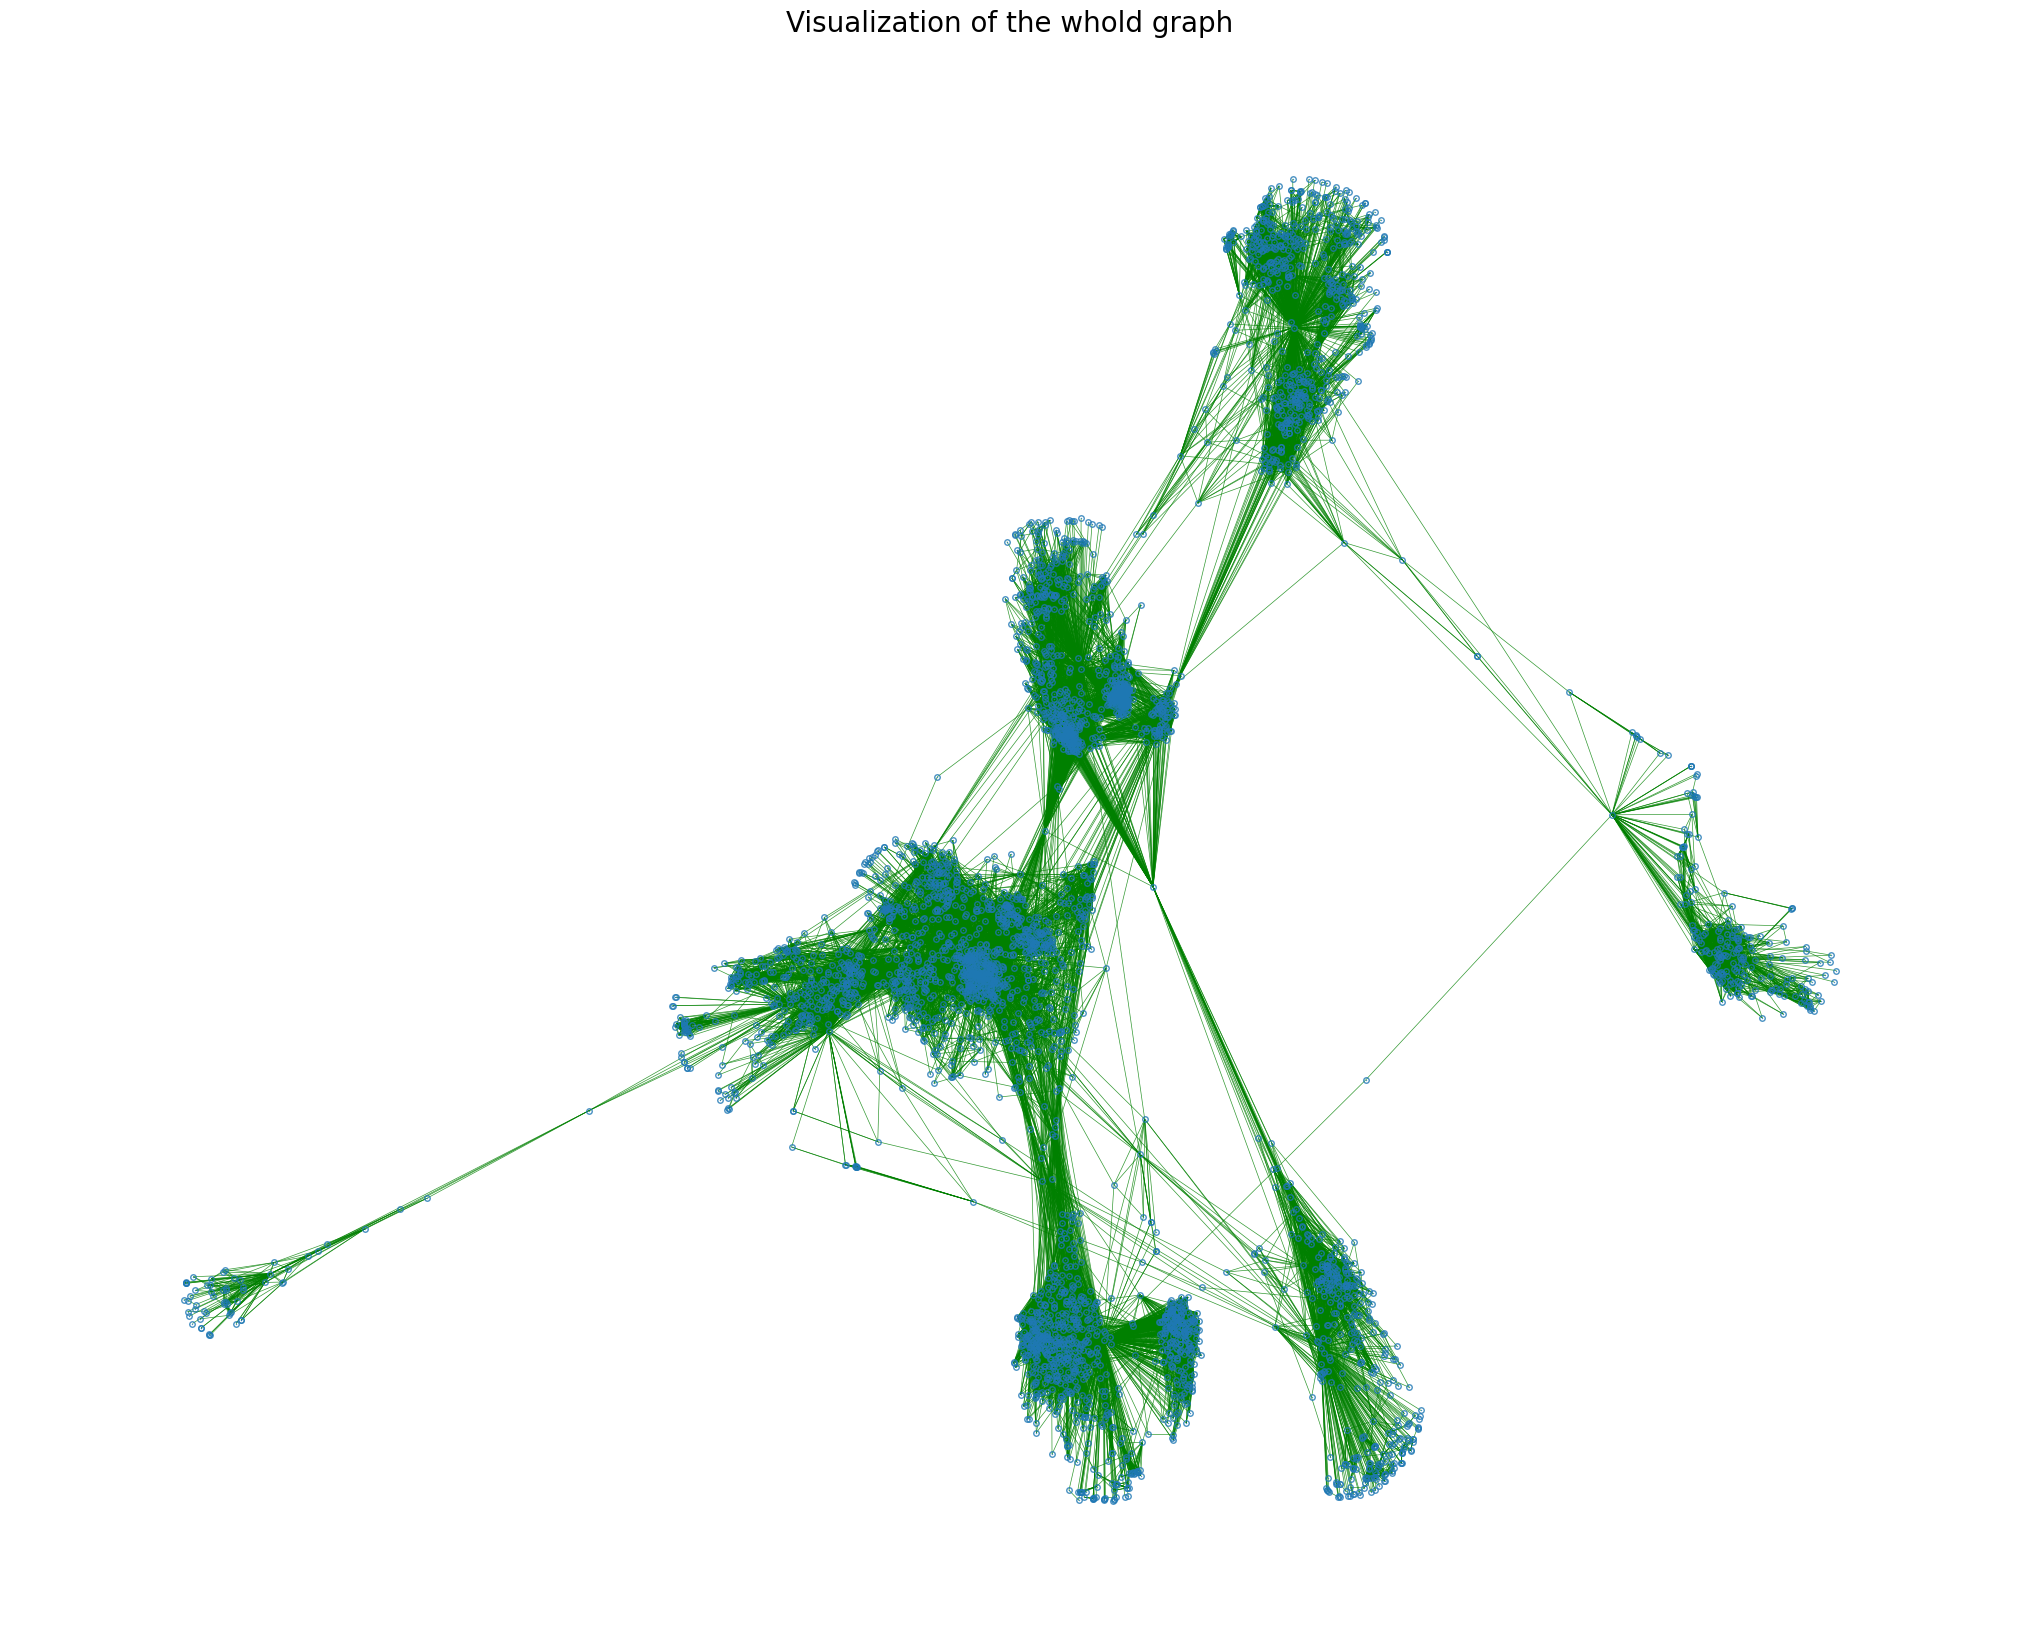

In [46]:
fig = plt.figure(figsize=(20,16))
net.draw(graph,
        with_labels=False,
        alpha=0.8,
        linewidths=4,
        width=0.5,
        font_size=5,
        edge_color="green",
         node_size=1)
plt.title("Visualization of the whold graph", fontdict={'fontsize': 20})

In [59]:
ego_graph_example = net.ego_graph(graph, "0", radius=1)

Text(0.5, 1.0, 'Node 0: Ego Network')

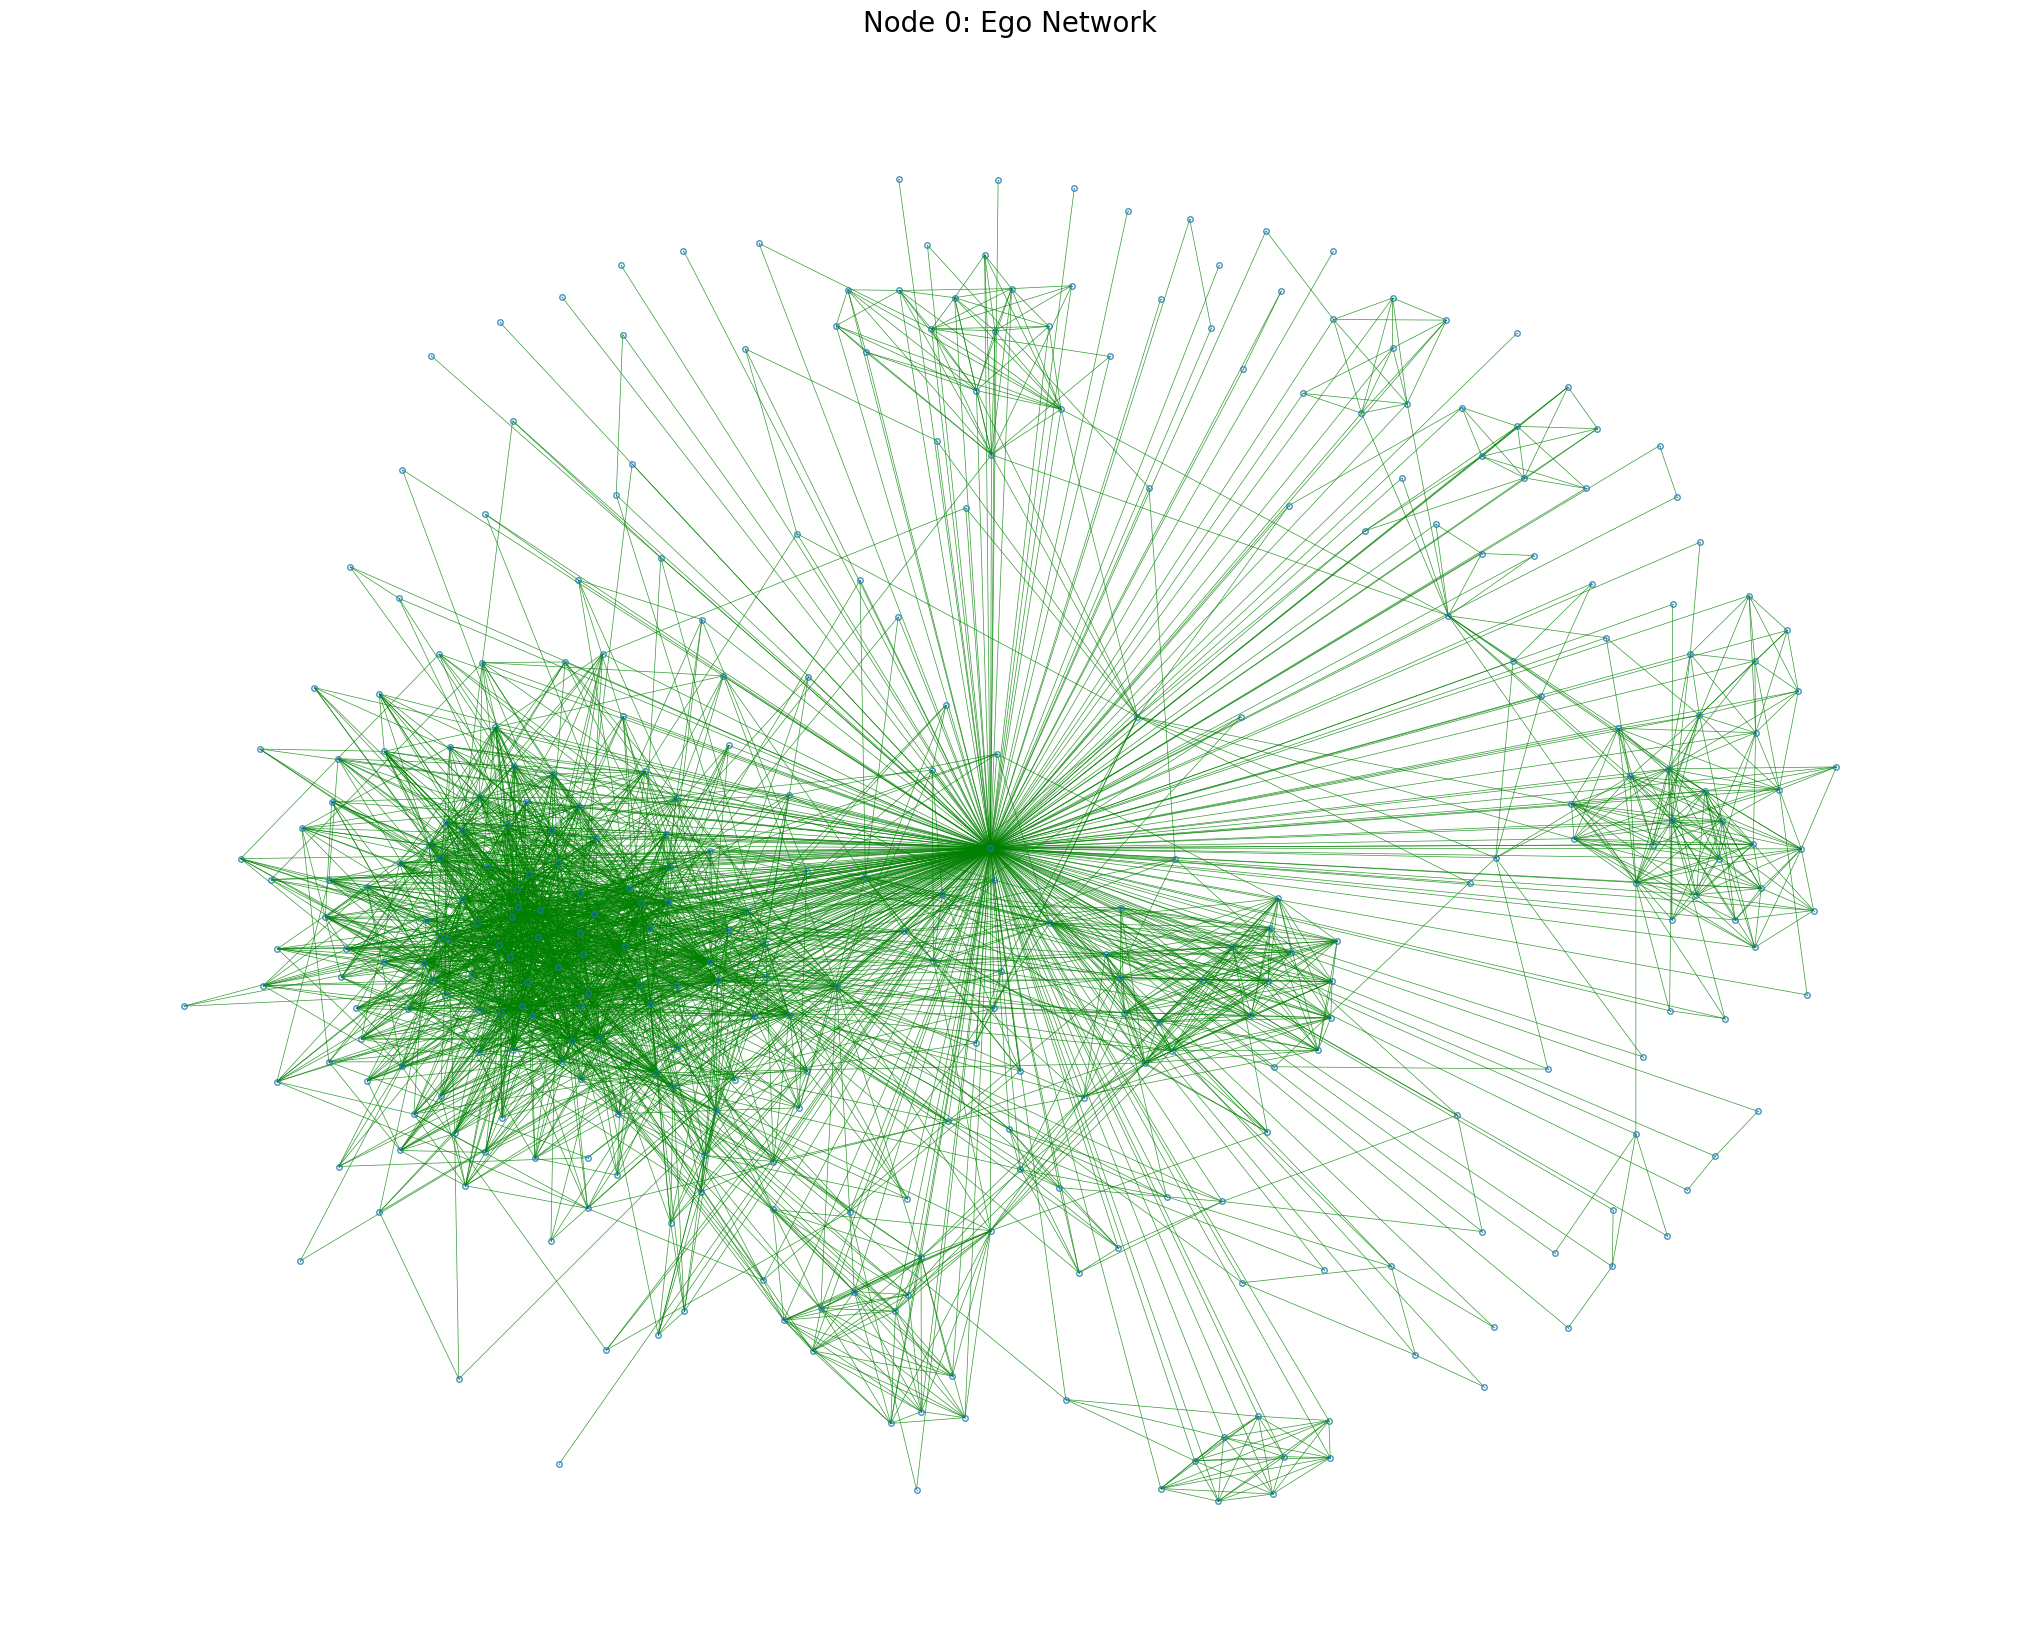

In [60]:
fig = plt.figure(figsize=(20,16))
net.draw(ego_graph_example,
        with_labels=False,
        alpha=0.8,
        linewidths=4,
        width=0.5,
        font_size=5,
        edge_color="green",
         node_size=1)
plt.title("Node 0: Ego Network", fontdict={'fontsize': 20})

#### Objective 1: Construction of a recommendation system with the capability to proffer specific individuals from the group of most influential people to newly onboarded users on a social platform

Construction of dataset to fulfill this objective

In [10]:
# Degree of all nodes
degree = dict(graph.degree)

In [7]:
# Sorting nodes according to their degree
sorted_degree_nodes = np.array(list(degree.keys()))[np.flip(np.argsort(list(degree.values())))]

In [8]:
np.array(np.unique(list(degree.values()), return_counts=True))

array([[   1,    2,    3,    4,    5,    6,    7,    8,    9,   10,   11,
          12,   13,   14,   15,   16,   17,   18,   19,   20,   21,   22,
          23,   24,   25,   26,   27,   28,   29,   30,   31,   32,   33,
          34,   35,   36,   37,   38,   39,   40,   41,   42,   43,   44,
          45,   46,   47,   48,   49,   50,   51,   52,   53,   54,   55,
          56,   57,   58,   59,   60,   61,   62,   63,   64,   65,   66,
          67,   68,   69,   70,   71,   72,   73,   74,   75,   76,   77,
          78,   79,   80,   81,   82,   83,   84,   85,   86,   87,   88,
          89,   90,   91,   92,   93,   94,   95,   96,   97,   98,   99,
         100,  101,  102,  103,  104,  105,  106,  107,  108,  109,  110,
         111,  112,  113,  114,  115,  116,  117,  119,  120,  121,  122,
         123,  124,  125,  126,  127,  128,  129,  130,  131,  132,  133,
         134,  135,  136,  137,  138,  139,  140,  141,  142,  144,  145,
         146,  147,  148,  149,  150, 

In [9]:
# considering nodes with 1, 2, 3, 4 degree
num = 75 + 98 + 93 + 99
small_degree_nodes = sorted_degree_nodes[-num:]

In [10]:
# considering top 50 nodes
high_degree_nodes = sorted_degree_nodes[:50]

In [11]:
# Returns neighbors of a node, excluding the target node if it's in the friends list
def get_neighbors(G, node, target=None):
    if target != None:
        return [e for e in list(dict(G[node]).keys()) if e != target]
    return list(dict(G[node]).keys())

# Returns the average of the features of neighbors and the node itself
def neighbor_walk_features(G, node, target=None):
    neighbors = np.array([node] + get_neighbors(G, node, target), dtype=int)
    features = feature_array[neighbors]
    return np.average(features, axis=0)

In [12]:
# Constructing the data as mentioned in the manuscript
first_dataset = pd.DataFrame(columns=["new_node", "suggested_node", "suggestion_score"])

In [13]:
for i in small_degree_nodes:
    neighbors = get_neighbors(graph, i)
    for n in neighbors:
        first_dataset.loc[len(first_dataset)] = [feature_array[int(i)], neighbor_walk_features(graph, n, i), 1]
        rand_node = n
        while rand_node in neighbors:
            rand_node = np.random.choice(high_degree_nodes, size=1)[0]
        first_dataset.loc[len(first_dataset)] = [feature_array[int(i)], neighbor_walk_features(graph, rand_node), 0]

In [14]:
first_dataset.shape

(1892, 3)

In [15]:
# Finding cosine similarity between the new node and suggested node
cosine_similarity = []
for i in range(len(first_dataset)):
    a = first_dataset.iloc[i]["new_node"]
    b = first_dataset.iloc[i]["suggested_node"]
    norm = np.linalg.norm(a) * np.linalg.norm(b)
    if norm == 0.0:
        cosine_similarity.append(0.0)
        continue
    sim = np.dot(a, b) / norm
    cosine_similarity.append(sim)

In [16]:
first_dataset["cosine_similarity"] = cosine_similarity

In [17]:
first_dataset.head()

,new_node,suggested_node,suggestion_score,cosine_similarity
0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0066985645933014355, 0.014354066985645933, ...",1,0.672302
1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.13478260869565217, 0.06521739130434782, 0.0...",0,0.724425
2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.08695652173913043, 0.0, 0.0, 0.08...",1,0.844653
3,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.014563106796116505, 0.06310679611...",0,0.612252
4,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.038461538461538464, 0.0, 0.038461...",1,0.811400


In [18]:
# Finding average cosine similarity of positive and negative suggestions
positive_cos_sim = []
negative_cos_sim = []
for i in range(len(cosine_similarity)):
    if first_dataset.loc[i]["suggestion_score"] == 1:
        positive_cos_sim.append(cosine_similarity[i])
    else:
        negative_cos_sim.append(cosine_similarity[i])
        
print(f"Average Cosine Similarity of New Nodes with friend: {np.average(positive_cos_sim)}")
print(f"Average Cosine Similarity of New Nodes with not friend: {np.average(negative_cos_sim)}")

Average Cosine Similarity of New Nodes with friend: 0.55033346347447
Average Cosine Similarity of New Nodes with not friend: 0.43804218444658394


In [19]:
# difference of nodes as input data
X = []
for i in range(len(first_dataset)):
    x = np.concatenate([first_dataset.loc[i]["suggested_node"] , first_dataset.loc[i]["new_node"]])
    X.append(x)

X = np.array(X)

In [20]:
y = np.copy(first_dataset.suggestion_score)

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Testing a set of binary classifier on giving a suggestion score where the suggested node should be a friend of new node or not

In [22]:
# Random Forest Classifier
rf = RandomForestClassifier(n_jobs=-1)
rf.fit(X_train, y_train)
print(f"Accuracy of Random Forest Classifier: {rf.score(X_test, y_test)}")
print(f"ROC AUC of Random Forest Classifier: {roc_auc_score(y_test, rf.predict(X_test))}")
print(f"F1 Score of Random Forest Classifier: {f1_score(y_test, rf.predict(X_test))}")

Accuracy of Random Forest Classifier: 0.9973614775725593
ROC AUC of Random Forest Classifier: 0.9972972972972973
F1 Score of Random Forest Classifier: 0.997289972899729


In [23]:
# Extra Tree Classifier
ext = ExtraTreesClassifier(n_jobs=-1)
ext.fit(X_train, y_train)
print(f"Accuracy of Extra Trees Classifier: {ext.score(X_test, y_test)}")
print(f"ROC AUC of Extra Trees Classifier: {roc_auc_score(y_test, ext.predict(X_test))}")
print(f"F1 Score of Extra Trees Classifier: {f1_score(y_test, ext.predict(X_test))}")

Accuracy of Extra Trees Classifier: 0.9973614775725593
ROC AUC of Extra Trees Classifier: 0.9972972972972973
F1 Score of Extra Trees Classifier: 0.997289972899729


In [24]:
# Extreme Gradient Boosting Classifier
xgb = XGBClassifier()
xgb.fit(X_train, y_train)
print(f"Accuracy of XGB Classifier: {xgb.score(X_test, y_test)}")
print(f"ROC AUC of XGB Classifier: {roc_auc_score(y_test, xgb.predict(X_test))}")
print(f"F1 Score of XGB Classifier: {f1_score(y_test, xgb.predict(X_test))}")

Accuracy of XGB Classifier: 0.9973614775725593
ROC AUC of XGB Classifier: 0.9972972972972973
F1 Score of XGB Classifier: 0.997289972899729


In [25]:
# Light Gradient Boosting Machine Classifier
lgb = LGBMClassifier()
lgb.fit(X_train, y_train)
print(f"Accuracy of LGBM Classifier: {lgb.score(X_test, y_test)}")
print(f"ROC AUC of LGBM Classifier: {roc_auc_score(y_test, lgb.predict(X_test))}")
print(f"F1 Score of LGBM Classifier: {f1_score(y_test, lgb.predict(X_test))}")

[LightGBM] [Info] Number of positive: 761, number of negative: 752
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007491 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19399
[LightGBM] [Info] Number of data points in the train set: 1513, number of used features: 1312
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502974 -> initscore=0.011897
[LightGBM] [Info] Start training from score 0.011897
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Accuracy of LGBM Classifier: 0.9973614775725593
ROC AUC of LGBM Classifier: 0.9972972972972973
F1 Score of LGBM Classifier: 0.997289972899729


#### Objective 2: Developing a recommender system designed for the purpose of suggesting new social connections to an individual.

Construction of dataset to fulfill this objective

In [11]:
num_nodes = len(feature_array)

In [12]:
u = []
v = []
for i in combined_edge_list:
    u.append(int(i[0]))
    v.append(int(i[1]))

In [13]:
# Constructing DGL graph
g = dgl.graph((u,v), num_nodes=num_nodes)

In [14]:
# Adding reverse edges as our graph is undirected
g = dgl.add_reverse_edges(g)

In [15]:
# Adding nodes features to the DGL graph
g.ndata['features'] = torch.from_numpy(np.array(feature_array, dtype=float))

In [16]:
# Dividing the data into train and test set
u, v = g.edges()

In [17]:
edge_id = np.arange(g.number_of_edges())
np.random.shuffle(edge_id)

In [18]:
train_size = int(len(edge_id) * 0.8)

In [19]:
positive_train_u = u[edge_id[:train_size]]
positive_train_v = v[edge_id[:train_size]]

positive_test_u = u[edge_id[train_size:]]
positive_test_v = v[edge_id[train_size:]]

In [20]:
# Finding all negative edges of the graph
adjacency_matrix = sp.coo_matrix((np.ones(len(u)), (u.numpy(), v.numpy())))
negative_adj_matrix = 1 - adjacency_matrix.todense() - np.eye(num_nodes)
negative_u, negative_v = np.where(negative_adj_matrix != 0)

In [21]:
# Choosing same number of negative edges as positive edges
negative_edge_id = np.random.choice(len(negative_u), g.number_of_edges())

In [22]:
negative_train_u = negative_u[negative_edge_id[:train_size]]
negative_train_v = negative_v[negative_edge_id[:train_size]]

negative_test_u = negative_u[negative_edge_id[train_size:]]
negative_test_v = negative_v[negative_edge_id[train_size:]]

In [23]:
# Removing test edges from the graph
train_g = dgl.remove_edges(g, edge_id[train_size:])

In [24]:
# Creating graph from positive and negative edges
positive_train_g = dgl.graph((positive_train_u, positive_train_v), num_nodes=num_nodes)
negative_train_g = dgl.graph((negative_train_u, negative_train_v), num_nodes=num_nodes)

positive_test_g = dgl.graph((positive_test_u, positive_test_v), num_nodes=num_nodes)
negative_test_g = dgl.graph((negative_test_u, negative_test_v), num_nodes=num_nodes)

In [25]:
# Constructing our Graph Neural Network with 2 SageConvolution Layers
class SAGE_GNN(nn.Module):
    def __init__(self, input_features, hidden_features, output_features):
        super(SAGE_GNN, self).__init__()
        self.sage1 = SAGEConv(input_features, hidden_features, 'mean', feat_drop=0.4)
        self.sage2 = SAGEConv(hidden_features, output_features, 'mean', feat_drop=0.4)
        self.double()

    def forward(self, g, input_feature):
        x = self.sage1(g, input_feature)
        x = F.relu(x)
        x = self.sage2(g, x)
        return x
    
class Dot_Score(nn.Module):
    def forward(self, g, h):
        with g.local_scope():
            g.ndata['h_feat'] = h
            g.apply_edges(fn.u_dot_v('h_feat', 'h_feat', 'score'))
            return g.edata['score'][:, 0]

In [26]:
# Loss Function and model performance metrics
def find_loss(pos, neg):
    pred = torch.cat([pos, neg])
    labels = torch.cat([torch.ones(pos.shape[0]), torch.zeros(neg.shape[0])])
    return F.binary_cross_entropy_with_logits(pred, labels)

def performance(pos, neg):
    pred = torch.cat([pos, neg]).numpy() > 0.5
    pred_threshold = pred > 0.5
    labels = torch.cat([torch.ones(pos.shape[0]), torch.zeros(neg.shape[0])]).numpy()
    roc = roc_auc_score(labels, pred)
    accuracy = accuracy_score(labels, pred_threshold)
    f1 = f1_score(labels, pred_threshold)
    return roc, accuracy, f1

In [27]:
# Declaring the model and optimizer
model = SAGE_GNN(train_g.ndata['features'].shape[1], 32, 16)
score = Dot_Score()

optimizer = torch.optim.Adam(itertools.chain(model.parameters(), score.parameters()), lr=0.01)
epochs = 100

In [28]:
for i in range(epochs):
    h_features = model(train_g, train_g.ndata["features"])
    positive_score = score(positive_train_g, h_features)
    negative_score = score(negative_train_g, h_features)
    loss = find_loss(positive_score, negative_score)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if i%10 == 0:
        print(f"Epoch: {i}, Loss: {loss}")

Epoch: 0, Loss: 0.7676995992660522
Epoch: 10, Loss: 0.5011232495307922
Epoch: 20, Loss: 0.4623660147190094
Epoch: 30, Loss: 0.4453415870666504
Epoch: 40, Loss: 0.4375683069229126
Epoch: 50, Loss: 0.4310102164745331
Epoch: 60, Loss: 0.42430347204208374
Epoch: 70, Loss: 0.41846269369125366
Epoch: 80, Loss: 0.41517046093940735
Epoch: 90, Loss: 0.4127105474472046


In [29]:
with torch.no_grad():
    positive_score = score(positive_test_g, h_features)
    negative_score = score(negative_test_g, h_features)
    auc, accuracy, f1 = performance(positive_score, negative_score)
    print(f"ROC AUC for our GNN: {auc}")
    print(f"Accuracy for our GNN: {accuracy}")
    print(f"F1 Score for our GNN: {f1}")

ROC AUC for our GNN: 0.9224372414574715
Accuracy for our GNN: 0.9224372414574715
F1 Score for our GNN: 0.9252059398095654
